### Real or Not? NLP with Disaster Tweets


#### Data Description:

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster.

#### Data:

Files:
1. train.csv - the training set
2. test.csv - the test set
3. sample_submission.csv - a sample submission file in the correct format

Columns:
1. id - a unique identifier for each tweet
2. text - the text of the tweet
3. location - the location the tweet was sent from (may be blank)
4. keyword - a particular keyword from the tweet (may be blank)
5. target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

### Importing Packages

In [1]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

### Loading data and basic analysis


In [2]:
train_data = pd.read_csv(r"C:\Users\Krithika.WINDOWS-CVA0M52\Desktop\mycasestudies\train.csv")
test_data = pd.read_csv(r"C:\Users\Krithika.WINDOWS-CVA0M52\Desktop\mycasestudies\test.csv")

In [3]:
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
train_data['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


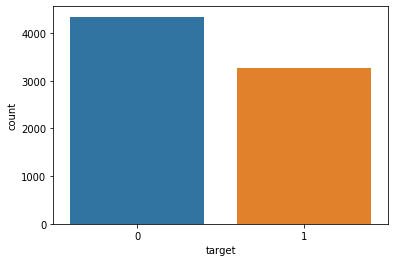

In [5]:
import seaborn as sns
print(sns.countplot(train_data['target']))


In [6]:
print(len(train_data['keyword']))
print(len(train_data['keyword'].dropna()))

7613
7552


In [7]:
print(len(train_data['location']))
print(len(train_data['location'].dropna()))

7613
5080


In [8]:
## target distribution ##
from plotly import tools
import plotly.offline as py
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
cnt_srs = train_data['target'].value_counts()
labels = (np.array(cnt_srs.index))
sizes = (np.array((cnt_srs / cnt_srs.sum())*100))

trace = go.Pie(labels=labels, values=sizes)
layout = go.Layout(
    title='Target distribution',
    font=dict(size=18),
    width=600,
    height=600,
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="usertype")

### Location data analysis:

In [9]:
train_data['location'].describe()

count     5080
unique    3341
top        USA
freq       104
Name: location, dtype: object

In [10]:
import re
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def removeurl(raw_text):
    clean_text = re.sub(r'^https?:\/\/.*[\r\n]*', '', raw_text, flags=re.MULTILINE)
    return clean_text

train_data['text']=train_data['text'].apply(lambda x:cleanhtml(x))
train_data['text']=train_data['text'].apply(lambda x:removeurl(x))
test_data['text']=test_data['text'].apply(lambda x:cleanhtml(x))
test_data['text']=test_data['text'].apply(lambda x:removeurl(x))

In [11]:
cnt_ = train_data['location'].value_counts()
cnt_.reset_index()
cnt_ = cnt_[:20,]
trace1 = go.Bar(
                x = cnt_.index,
                y = cnt_.values,
                name = "Number of tweets in dataset according to location",
                marker = dict(color = 'rgba(200, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )

data = [trace1]
layout = go.Layout(barmode = "group",title = 'Number of tweets in dataset according to location')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [12]:
train1_df = train_data[train_data["target"]==1]
train0_df = train_data[train_data["target"]==0]
cnt_1 = train1_df['location'].value_counts()
cnt_1.reset_index()
cnt_1 = cnt_1[:20,]

cnt_0 = train0_df['location'].value_counts()
cnt_0.reset_index()
cnt_0 = cnt_0[:20,]

trace1 = go.Bar(
                x = cnt_1.index,
                y = cnt_1.values,
                name = "Number of tweets about real disaster location wise",
                marker = dict(color = 'rgba(255, 74, 55, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )
trace0 = go.Bar(
                x = cnt_0.index,
                y = cnt_0.values,
                name = "Number of tweets other than real disaster location wise",
                marker = dict(color = 'rgba(79, 82, 97, 0.5)',
                             line=dict(color='rgb(0,0,0)',width=1.5)),
                )


data = [trace0,trace1]
layout = go.Layout(barmode = 'stack',title = 'Number of tweets in dataset according to location')
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

In [13]:
Y_train = train_data['target']
X_train = train_data.drop(columns = ['target'])
X_test = test_data
X_train.head()


,id,keyword,location,text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...


###  Text data analysis:

In [14]:
import re
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [15]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [16]:
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\http co',' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [17]:
pp_text = preprocess_text(X_train['text'])
pp_text[0:10]

100%|███████████████████████████████████| 7613/7613 [00:00<00:00, 11223.05it/s]


['deeds reason earthquake may allah forgive us',
 'forest fire near la ronge sask canada',
 'residents asked ishelter place notified officers no evacuation shelter place orders expected',
 '13 000 people receive wildfires evacuation orders california',
 'got sent photo ruby alaska smoke wildfires pours school',
 'rockyfire update california hwy 20 closed directions due lake county fire cafire wildfires',
 'flood disaster heavy rain causes flash flooding streets manitou colorado springs areas',
 'top hill see fire woods',
 'emergency evacuation happening building across street',
 'afraid tornado coming area']

In [18]:
pp_test = preprocess_text(test_data['text'])

100%|███████████████████████████████████| 3263/3263 [00:00<00:00, 12210.69it/s]


In [19]:
pp_test[0:20]

['happened terrible car crash',
 'heard earthquake different cities stay safe everyone',
 'forest fire spot pond geese fleeing across street cannot save',
 'apocalypse lighting spokane wildfires',
 'typhoon soudelor kills 28 china taiwan',
 'shaking earthquake',
 'would probably still show life arsenal yesterday eh eh',
 'hey',
 'nice hat',
 'fuck',
 'no not like cold',
 'nooooooooo not',
 'no not tell',
 '',
 'awesome',
 'birmingham wholesale market ablaze bbc news fire breaks birmingham wholesale market http co irwqcezweu',
 'sunkxssedharry wear shorts race ablaze',
 'previouslyondoyintv toke makinwa marriage crisis sets nigerian twitter ablaze http co cmghxba2xi',
 'check http co roi2nsmejj http co 3tj8zjin21 http co yduixefipe http co lxtjc87kls nsfw',
 'psa splitting personalities techies follow ablaze co burners follow ablaze']

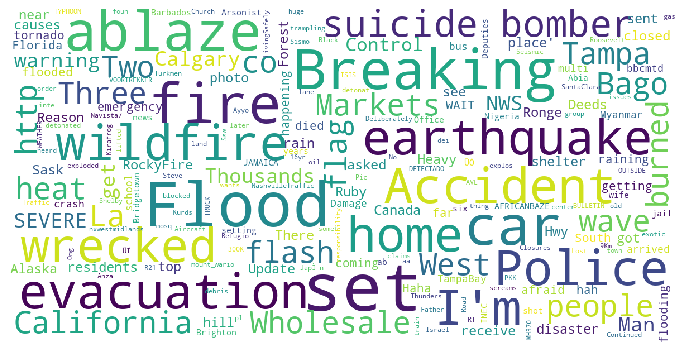

In [20]:

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(stopwords)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(train_data[train_data['target']==1]['text'])

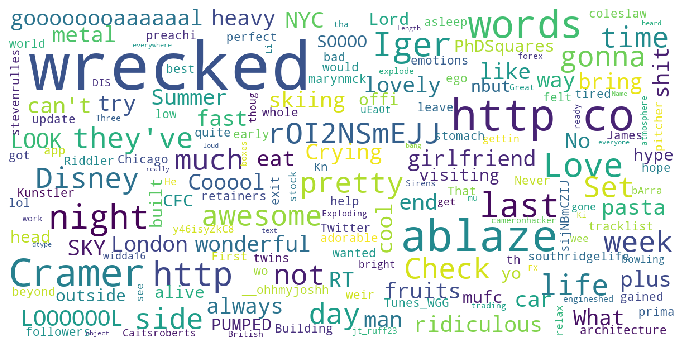

In [21]:
show_wordcloud(train_data[train_data['target']==0]['text'])

### Keyword Analysis:

In [23]:
k1 = train_data[train_data['target']==1]['keyword']
k2 = train_data[train_data['target']==0]['keyword']
v1 = k1.value_counts()
v2 = k2.value_counts()
print(v1[0:20])
print('----')
print(v2[0:20])



derailment             39
wreckage               39
outbreak               39
debris                 37
typhoon                37
oil%20spill            37
suicide%20bombing      32
evacuated              32
rescuers               32
suicide%20bomb         32
nuclear%20disaster     31
razed                  31
suicide%20bomber       30
earthquake             30
airplane%20accident    30
bridge%20collapse      29
wildfire               29
collision              29
sandstorm              28
drought                28
Name: keyword, dtype: int64
----
body%20bags    40
harm           37
armageddon     37
ruin           36
wrecked        36
deluge         36
siren          35
twister        35
fear           35
explode        35
screaming      34
panic          34
aftershock     34
blazing        33
sinking        33
traumatised    33
blaze          33
blizzard       33
crush          33
curfew         32
Name: keyword, dtype: int64


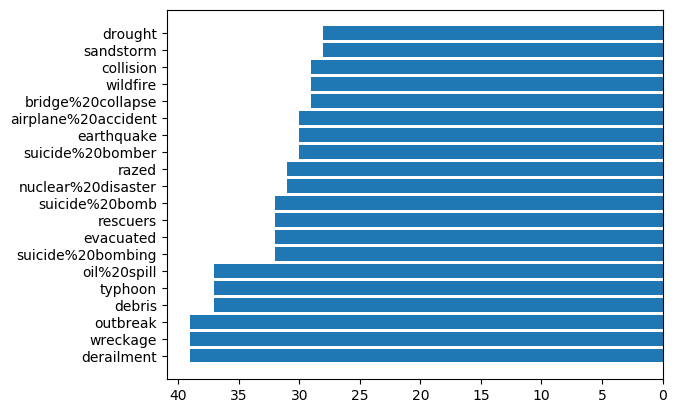

In [24]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(v1.index.tolist()[0:20], v1.tolist()[0:20] , align='center')
ax.invert_xaxis()
plt.show()

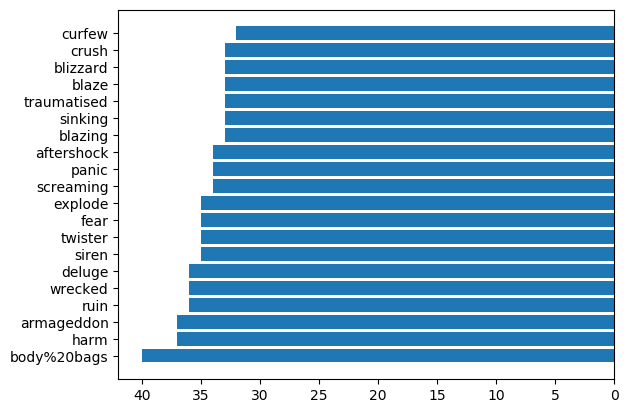

In [25]:
plt.rcdefaults()
fig, ax = plt.subplots()
ax.barh(v2.index.tolist()[0:20], v2.tolist()[0:20] , align='center')
ax.invert_xaxis()
plt.show()

In [26]:
train_data["num_words"] = train_data["text"].apply(lambda x: len(str(x).split()))
test_data["num_words"] = test_data["text"].apply(lambda x: len(str(x).split()))
test_data.head()

,id,keyword,location,text,num_words
0,0,NaN,NaN,Just happened a terrible car crash,6
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",9
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",19
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,4
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,8


#Meta features:
1. word count
2. unique words
3. hashtags
4. 

In [27]:
train_data["num_unique_words"] = train_data["text"].apply(lambda x: len(set(str(x).split())))
test_data["num_unique_words"] = test_data["text"].apply(lambda x: len(set(str(x).split())))
train_data.head()
        

,id,keyword,location,text,target,num_words,num_unique_words
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,20
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,15


In [28]:
import re
train_data["hashtags"] = train_data["text"].apply(lambda x:  ' , '.join(re.findall(r"#(\w+)", x) ))
test_data["hashtags"] = test_data["text"].apply(lambda x: ' , '.join(re.findall(r"#(\w+)", x)))
train_data.head()

,id,keyword,location,text,target,num_words,num_unique_words,hashtags
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,13,earthquake
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,7,
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,20,
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,8,wildfires
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,15,"Alaska , wildfires"


In [96]:
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit_transform(train_data['text'].values.tolist() + test_data['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_data['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_data['text'].values.tolist())

In [99]:
tfidf_vec1 = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec1.fit_transform(train_data['hashtags'].values.tolist() + test_data['hashtags'].values.tolist())
train_tfidf1 = tfidf_vec1.transform(train_data['hashtags'].values.tolist())
test_tfidf1 = tfidf_vec1.transform(test_data['hashtags'].values.tolist())

In [102]:
from scipy.sparse import hstack
tr1 = hstack((train_tfidf,train_tfidf1)).tocsr()
te1 = hstack((test_tfidf,test_tfidf1)).tocsr()


In [104]:
print("Final Data matrix")
print(tr1.shape)
print(te1.shape)

Final Data matrix
(7613, 173965)
(3263, 173965)
